<a href="https://colab.research.google.com/github/hien25661/MachineLearningModel/blob/main/ClippedFaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clipped Face Image Detection
- Problem : Detect the Bouding box and classify the Explicic Image
 + Positive sample: Clipped Face Image  
 + Negative sample: None Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting Project 

###1.Clone Tensor Model git project

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3632, done.
remote: Counting objects: 100% (3632/3632), done.
remote: Compressing objects: 100% (3019/3019), done.
remote: Total 3632 (delta 962), reused 1523 (delta 558), pack-reused 0
Receiving objects: 100% (3632/3632), 47.11 MiB | 26.85 MiB/s, done.
Resolving deltas: 100% (962/962), done.


###2.Run batch

In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import glob
import os
import cv2
from keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import xml.etree.ElementTree as ET
from numpy import asarray

tf.get_logger().setLevel('ERROR')

##1. Load Dataset
###1.1 Data Pre-Processing

In [ ]:
SKIP_NEGATIVES = False
NEGATIVE_CLASS = "None"
width = 224
height = 224
num_classes = 2
classes = ["CutFace"]

#### Convert XML Image File to **CSV**

In [44]:
def xml_to_csv(path, skipNegatives):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        if root.find('object'):
            for member in root.findall('object'):
                bbx = member.find('bndbox')
                xmin = round(float(bbx.find('xmin').text))
                ymin = round(float(bbx.find('ymin').text))
                xmax = round(float(bbx.find('xmax').text))
                ymax = round(float(bbx.find('ymax').text))
                label = member.find('name').text
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        label,
                        xmin,
                        ymin,
                        xmax,
                        ymax
                        )
                print(value)
                xml_list.append(value)
        elif not skipNegatives:
            value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        NEGATIVE_CLASS,
                        0,
                        0,
                        0,
                        0
                        )
            print(value)
            xml_list.append(value)

    column_name = ['filename', 'width', 'height',
                   'className', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

image_path = os.path.join('/content/drive/MyDrive/MachineMags/FaceCutDetection', 'images')
xml_df = xml_to_csv(image_path, SKIP_NEGATIVES)
xml_df.to_csv('/content/drive/MyDrive/MachineMags/FaceCutDetection/data/data.csv', index=None)
print('Successfully converted xml to csv.')

    

('1 (1).jpg', 500, 750, 'CutFace', 54, 271, 465, 750)
('1 (2).jpg', 736, 981, 'CutFace', 182, 36, 599, 499)
('1 (3).jpg', 566, 800, 'CutFace', 116, 4, 492, 370)
('1 (4).jpg', 720, 960, 'CutFace', 105, 356, 610, 806)
('1 (5).jpg', 961, 1200, 'CutFace', 106, 292, 857, 973)
('1 (6).jpg', 644, 900, 'CutFace', 43, 307, 605, 731)
('1 (7).jpg', 768, 1024, 'CutFace', 100, 18, 537, 766)
('1 (8).jpg', 1280, 1792, 'CutFace', 582, 9, 1067, 1230)
('1 (9).jpg', 961, 1200, 'CutFace', 432, 6, 859, 968)
('1 (10).jpg', 1066, 1332, 'CutFace', 227, 2, 722, 815)
('1 (11).jpg', 3840, 5760, 'CutFace', 740, 1534, 3407, 3775)
('1 (12).jpg', 1280, 1920, 'CutFace', 117, 715, 1117, 1464)
('1 (13).jpg', 888, 1050, 'CutFace', 41, 50, 616, 809)
('1 (14).jpg', 736, 979, 'CutFace', 217, 123, 577, 665)
('1 (15).jpg', 599, 731, 'CutFace', 205, 76, 474, 499)
('1 (16).jpg', 618, 962, 'CutFace', 162, 150, 553, 712)
('1 (18).jpg', 640, 640, 'CutFace', 147, 234, 517, 560)
('1 (20).jpg', 750, 898, 'CutFace', 108, 113, 443, 80

### 1.2 Data Tranform

#### Read CSV to collect data

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/MachineMags/FaceCutDetection/data/data.csv')

data = []
labels = []
bboxes = []
imagePaths = []
for row in df.itertuples(index=True, name='Pandas'):
    image_path = '/content/drive/MyDrive/MachineMags/FaceCutDetection/images/' + str(row.filename)
    image = cv2.imread(image_path)
    print(image_path)
    y_ = image.shape[0]
    x_ = image.shape[1]

    targetSize = 224

    x_scale = targetSize / x_
    y_scale = targetSize / y_

    image = cv2.resize(image, (targetSize, targetSize));

    (origLeft, origTop, origRight, origBottom) = ((int(row.xmax), int(row.ymax), int(row.xmin), int(row.ymin)))

    x = int(np.round(origLeft * x_scale))
    y = int(np.round(origTop * y_scale))
    xmax = int(np.round(origRight * x_scale))
    ymax = int(np.round(origBottom * y_scale))

    data.append(np.array(image))
    bboxes.append((x, y, xmax, ymax))
    imagePaths.append(image_path)
    print(row.className)
    labels.append(row.className)


In [46]:
data = np.array(data, dtype="float32")/255
bboxes = np.array(bboxes, dtype="float32")/255
imagePaths=np.array(imagePaths)
labels=np.array(labels)

In [47]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
if len(lb.classes_) == 2:
    labels = tf.keras.utils.to_categorical(labels)

2


###1.3 Data Spliting

In [48]:
split = train_test_split(data, labels, bboxes, imagePaths,
   test_size=0.20, random_state=42)

(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


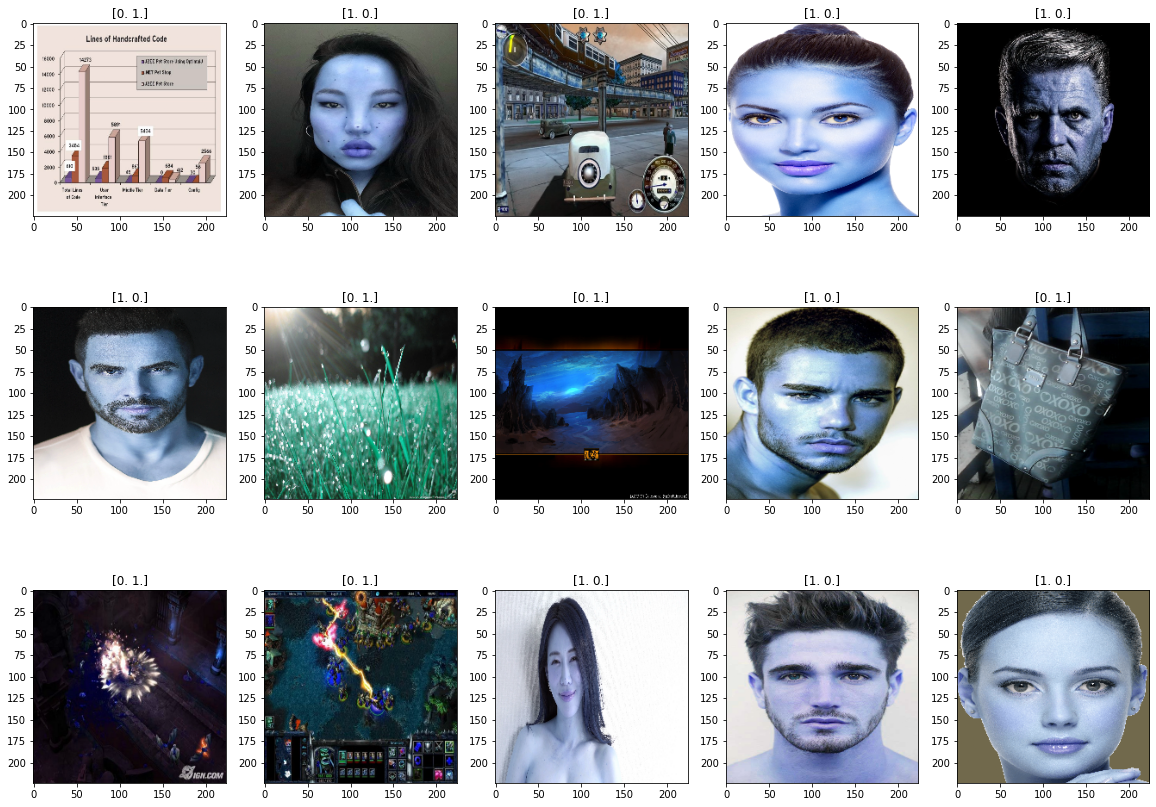

In [49]:
plt.figure(figsize=(20, 20))
for index, img in enumerate(trainImages[0:15]):
  plt.subplot(4,5, index+1)
  plt.imshow(img)
  plt.title(trainLabels[0:15][index])
plt.show()

##2. Train Model

### Load pre-trained Model

In [50]:
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=tf.keras.Input(shape=(224, 224, 3)))

In [51]:
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = tf.keras.layers.Flatten()(flatten)

### Build a model

In [52]:
# bounding box coordinates
bboxHead = tf.keras.layers.Dense(128, activation="relu")(flatten)
bboxHead = tf.keras.layers.Dense(64, activation="relu")(bboxHead)
bboxHead = tf.keras.layers.Dense(32, activation="relu")(bboxHead)
bboxHead = tf.keras.layers.Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)

# the class label
softmaxHead = tf.keras.layers.Dense(512, activation="relu")(flatten)
softmaxHead = tf.keras.layers.Dropout(0.5)(softmaxHead)
softmaxHead = tf.keras.layers.Dense(512, activation="relu")(softmaxHead)
softmaxHead = tf.keras.layers.Dropout(0.5)(softmaxHead)
softmaxHead = tf.keras.layers.Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)

In [54]:
model = tf.keras.models.Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}
INIT_LR = 1e-4
opt = tf.keras.optimizers.Adam(lr=INIT_LR)
lossWeights = {
"class_label": 1.0,
"bounding_box": 1.0
}
model.compile(loss=losses, optimizer='Adam', metrics=["accuracy"], loss_weights=lossWeights)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [55]:
import datetime

epochs = 40
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=4,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

29/29 [==============================] - 8s 269ms/step - loss: 0.0373 - bounding_box_loss: 0.0373 - class_label_loss: 3.1648e-09 - bounding_box_accuracy: 0.3628 - class_label_accuracy: 1.0000 - val_loss: 0.0290 - val_bounding_box_loss: 0.0290 - val_class_label_loss: 5.4260e-07 - val_bounding_box_accuracy: 0.4138 - val_class_label_accuracy: 1.0000
Epoch 18/40
29/29 [==============================] - 8s 272ms/step - loss: 0.1793 - bounding_box_loss: 0.0282 - class_label_loss: 0.1511 - bounding_box_accuracy: 0.3717 - class_label_accuracy: 0.9823 - val_loss: 0.0291 - val_bounding_box_loss: 0.0226 - val_class_label_loss: 0.0065 - val_bounding_box_accuracy: 0.3103 - val_class_label_accuracy: 1.0000
Epoch 19/40
29/29 [==============================] - 8s 268ms/step - loss: 0.0253 - bounding_box_loss: 0.0253 - class_label_loss: 2.3209e-08 - bounding_box_accuracy: 0.4071 - class_label_accuracy: 1.0000 - val_loss: 0.0145 - val_bounding_box_loss: 0.0145 - val_class_label_loss: 0.0000e+00 - val_bo

##3.Evaluation

Text(0.5, 1.0, 'Training and Validation bounding Loss')

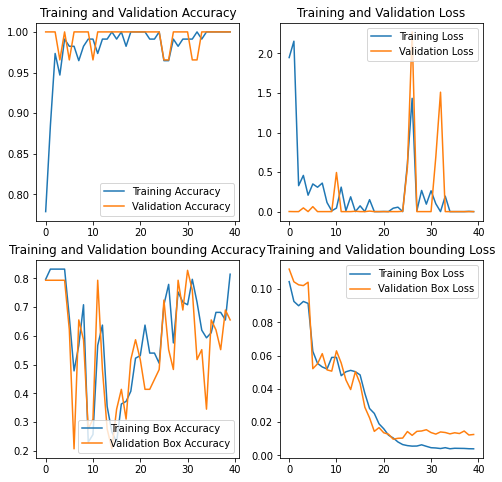

In [61]:
acc = history.history['class_label_accuracy']
val_acc = history.history['val_class_label_accuracy']

loss = history.history['class_label_loss']
val_loss = history.history['val_class_label_loss']


box_acc = history.history['bounding_box_accuracy']
val_box_acc = history.history['val_bounding_box_accuracy']

box_loss = history.history['bounding_box_loss']
val_box_loss = history.history['val_bounding_box_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.subplot(2, 2, 3)
plt.plot(epochs_range, box_acc, label='Training Box Accuracy')
plt.plot(epochs_range, val_box_acc, label='Validation Box Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation bounding Accuracy')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, box_loss, label='Training Box Loss')
plt.plot(epochs_range, val_box_loss, label='Validation Box Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation bounding Loss')

In [ ]:
%reload_ext tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs



In [62]:
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import glob

['/content/drive/MyDrive/MachineMags/ImageDirection/raw/img.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_1.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_2.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_3.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_4.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_5.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_6.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_7.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_8.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_9.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_10.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_11.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_12.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_13.png', '/content/drive/MyDrive/MachineMags/ImageDirection/raw/img_

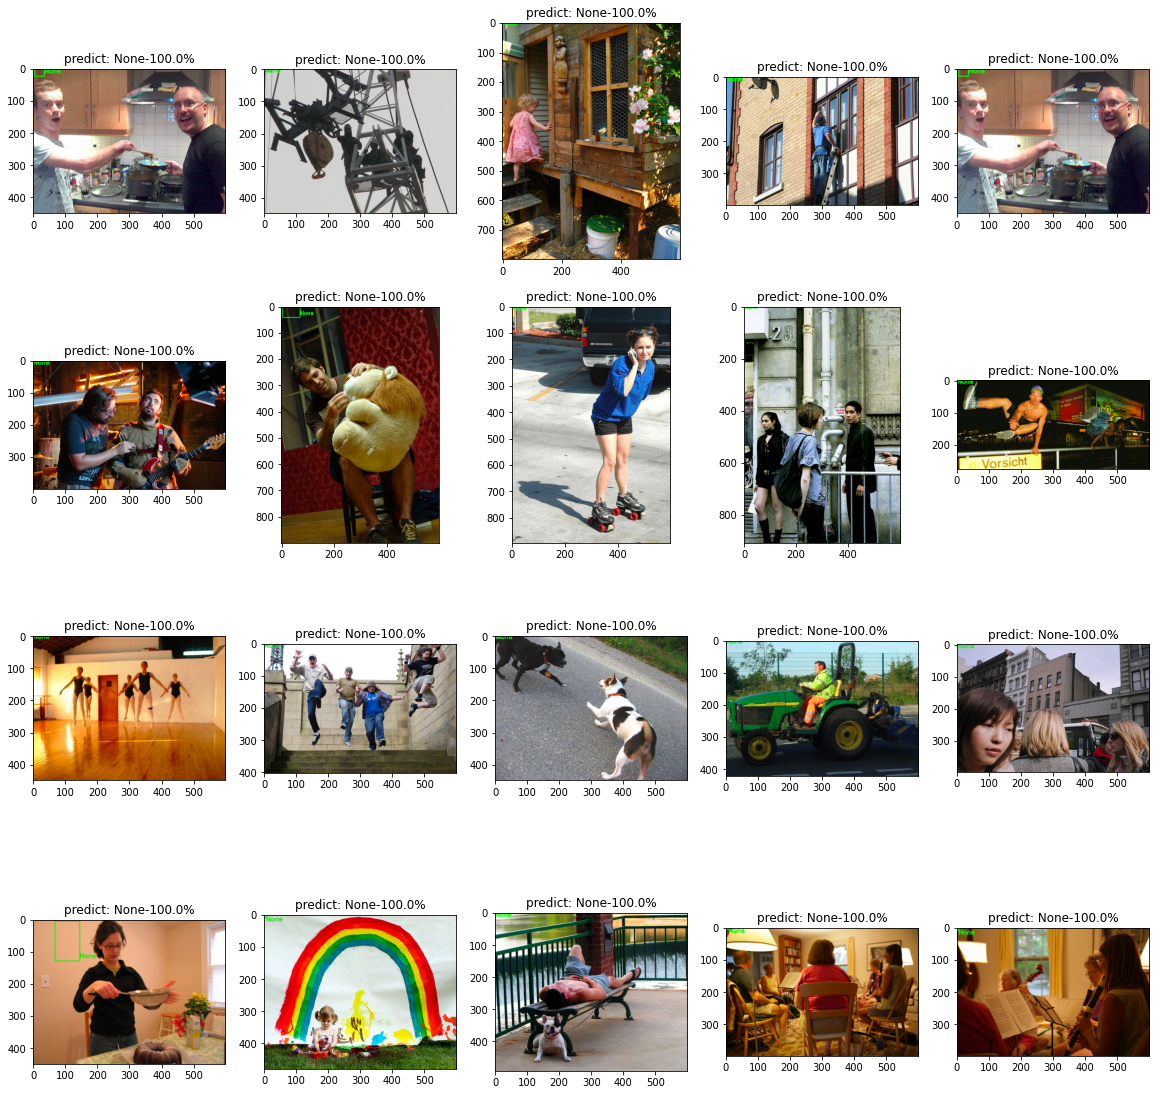

In [90]:
# load the input image (in Keras format) from disk and preprocess
# it, scaling the pixel intensities to the range [0, 1]

imagePaths_=[x for x in glob.glob('/content/drive/MyDrive/MachineMags/ImageDirection/raw/*')]    
print(imagePaths_)
plt.figure(figsize=(20, 20))
for index, imagePath in enumerate(imagePaths_[0:20]):
  image = load_img(imagePath, target_size=(width, height))
  image = img_to_array(image)/255.0
  image = np.expand_dims(image, axis=0)

  # predict the bounding box of the object along with the class
  # label
  (boxPreds, labelPreds) = model.predict(image)
  # print(boxPreds)
  (startX, startY, endX, endY) = boxPreds[0]
  # determine the class label with the largest predicted
  # probability
  i = np.argmax(labelPreds, axis=1)
  # print(labelPreds[0][i])
  label = lb.classes_[i][0]
  # print(label)
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  # scale the predicted bounding box coordinates based on the image
  # dimensions
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  # print(startX)
  # print(startY)
  # print(endX)
  # print(endY)

  # draw the predicted bounding box and class label on the image
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
      0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (startX, startY), (endX, endY),   (0, 255, 0), 2)
  plt.subplot(4,5, index + 1)
  plt.title('predict: '+label + "-"+str(round(labelPreds[0][i][0] * 100, 2)) + '%')
  plt.imshow(image)
plt.show()